<a href="https://colab.research.google.com/github/SiriBatchu/Deepseek_Janus/blob/main/Janus/DeepSeek_Janus_Pro_7b_GenerateTextFromImage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/deepseek-ai/Janus
%cd Janus
!pip install -e .

Cloning into 'Janus'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 115 (delta 23), reused 22 (delta 14), pack-reused 74 (from 1)
Receiving objects: 100% (115/115), 7.16 MiB | 29.44 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/Janus
Obtaining file:///content/Janus
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for janus (pyproject.toml) ... done
  Created wheel for janus: filename=janus-1.0.0-0.editable-py3-none-any.whl size=15926 sha256=fd557ad260e8e3eefbb4c460a52ce0b43d19e141dd6a3c54f63f55ed4a7c0280
  Stored in directory: /tmp/pip-ephem-wheel-cache-m8rk75k4/wheels/04/ee/d6/76a460ef4080a263aa86cc3fdbb1c5bb29f559fbd8155d1c83
Successfully built janus


In [ ]:
import torch
from transformers import AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images

In [ ]:
# specify the path to the model
model_path = "deepseek-ai/Janus-Pro-7B"
vl_chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer

vl_gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
vl_gpt = vl_gpt.to(torch.bfloat16).cuda().eval()

Some kwargs in processor config are unused and will not have any effect: ignore_id, num_image_tokens, image_tag, mask_prompt, add_special_token, sft_format. 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
conversation = [
    {
        "role": "<|User|>",
        "content": f"<image_placeholder>\n What is this place. Tell me it's history",
        "images": ['/content/mountain.png'],
    },
    {"role": "<|Assistant|>", "content": ""},
]

# load images and prepare for inputs
pil_images = load_pil_images(conversation)
prepare_inputs = vl_chat_processor(
    conversations=conversation, images=pil_images, force_batchify=True
).to(vl_gpt.device)

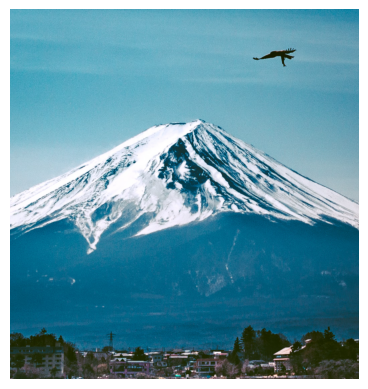

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image = Image.open('/content/mountain.png')

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:

# # run image encoder to get the image embeddings
inputs_embeds = vl_gpt.prepare_inputs_embeds(**prepare_inputs)

# # run the model to get the response
outputs = vl_gpt.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=prepare_inputs.attention_mask,
    pad_token_id=tokenizer.eos_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    max_new_tokens=512,
    do_sample=False,
    use_cache=True,
)

answer = tokenizer.decode(outputs[0].cpu().tolist(), skip_special_tokens=True)
print(f"{prepare_inputs['sft_format'][0]}", answer)


You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.

<|User|>: <image_placeholder>
 What is this place. Tell me it's history

<|Assistant|>: This image shows Mount Fuji, a prominent and iconic mountain in Japan. Mount Fuji is known for its symmetrical conical shape and is the highest mountain in Japan, standing at 3,776 meters (12,389 feet) above sea level. It is a sacred mountain in Shinto religion and is considered a symbol of Japan.

Mount Fuji has a rich history dating back over 100 million years. It is part of the Japanese Alps and has been a subject of artistic and cultural expression for centuries. The mountain has been featured in numerous works of art, including paintings, poetry, and films.

In the Edo period (1603-1868), Mount Fuji was considered a sacred mountain and was often depicted in ukiyo-e, a genre of Japanese woodblock prints. The mo